# ATLAS xAOD

ATLAS has several internal binary formats. These are not accessible in ROOT unless you load a full set of release libraries, and while they are often stored in a columnar format (not easily accessible!), the software presents and forces interactions on a per-event view.

ServiceX's job is to take any input and transform it into columnar data. It has a transformer that is designed to do this for the ATLAS xAOD format.

In [6]:
import mplhep as hep
import awkward as ak
from hist import Hist
import matplotlib.pyplot as plt
import vector

hep.style.use(hep.style.ATLAS)
vector.register_awkward()

## Getting a dataset

For this demo lets use an ATLAS release 21 dataset that is available on the GRID: `rucio://mc16_13TeV:mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_e5984_s3126_s3136_r10724_r10726_p4164`

In [2]:
from func_adl_servicex_xaodr21 import SXDSAtlasxAODR21, calib_tools

ds_name = "rucio://mc16_13TeV:mc16_13TeV.361106.PowhegPythia8EvtGen_AZNLOCTEQ6L1_Zee.deriv.DAOD_PHYS.e3601_e5984_s3126_s3136_r10724_r10726_p4164"
ds = SXDSAtlasxAODR21(f'{ds_name}?files=20&get=available')

# I'll come back to this step
ds = calib_tools.query_update(ds,
    perform_overlap_removal=False
)

## Jets

Lets do the same query as we did before - but note we no longer have to build the EDM - it is already baked into the xAOD. This does mean, of course, you need to use the baked-in xAOD.

In [3]:
all_jets = (ds
    .Select(lambda e: e.Jets())
)

In [4]:
filtered_jets = (all_jets
    .Select(lambda jets: jets.Where(lambda j: j.pt()/1000.0 > 30 and abs(j.eta()) < 2.4))
)

In [5]:
jet_momenta = (filtered_jets
    .Select(lambda jets: {
        'px': jets.Select(lambda j: j.px()/1000.0),
        'py': [j.py()/1000.0 for j in jets],
        'pz': [j.pz()/1000.0 for j in jets],
    })
    .AsAwkwardArray()
    .value()
)

rucio://mc16_13TeV:m...:   0%|          | 0/9000000000.0 [00:00]

        rucio://mc16_13TeV:m... Downloaded:   0%|          | 0/9000000000.0 [00:00]

Now we can do the same thing we've done before to plot them.

In [7]:
jet_v = ak.Array(jet_momenta, with_name='Momentum3D')

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


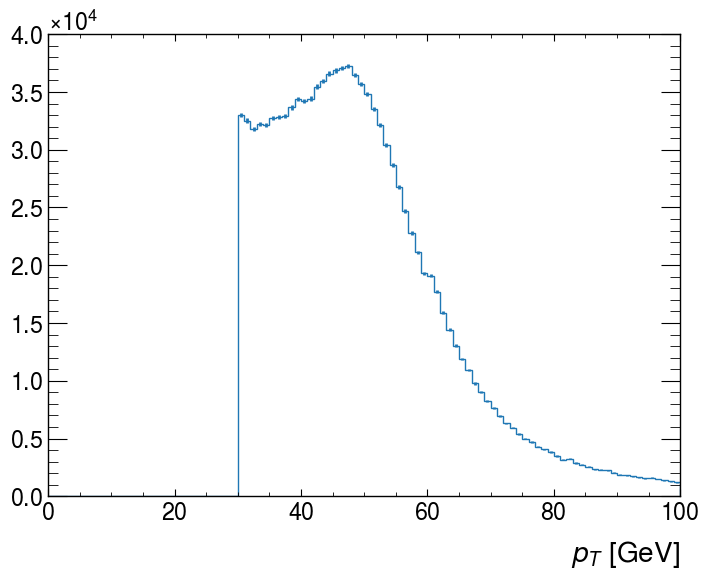

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


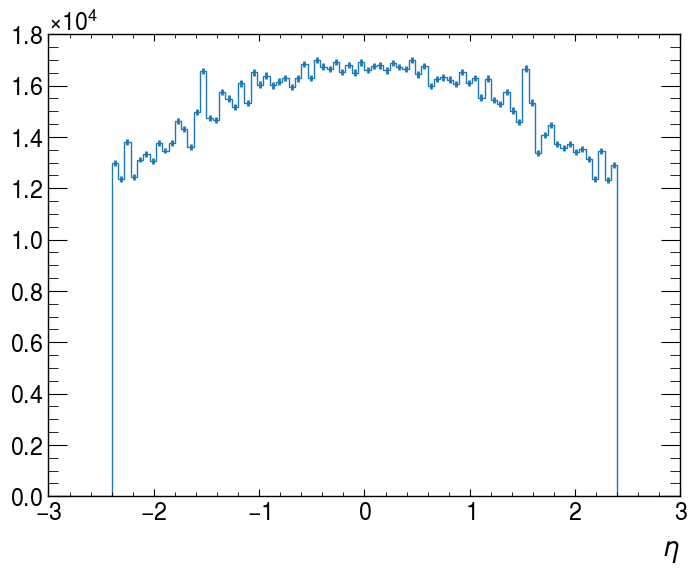

c:\Users\gordo\Code\iris-hep\agc-workshop-2022-servicex\.venv\lib\site-packages\mplhep\utils.py:211: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  warnings.warn(


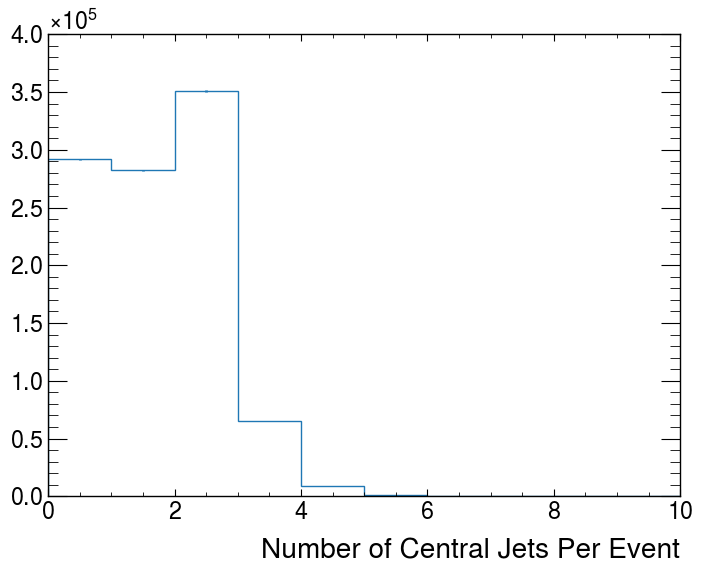

In [15]:
h = (
  Hist.new
  .Reg(100, 0 , 100, name="pt", label="$p_T$ [GeV]")
  .Int64()
)
h.fill(ak.flatten(jet_v.pt))
h.plot()
plt.show()

h = (
  Hist.new
  .Reg(100, -3.0 , 3.0, name="eta", label=r"$\eta$")
  .Int64()
)
h.fill(ak.flatten(jet_v.eta))
h.plot()
plt.show()

h = (
  Hist.new
  .Reg(10, 0, 10.0, name="njet", label=r"Number of Central Jets Per Event")
  .Int64()
)
h.fill(ak.count(jet_v.eta, axis=1))
h.plot()
plt.show()